In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tkinter as tk
from tkinter import ttk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Load and prepare data
def load_data():
    df = pd.read_csv('data.csv')  # Changed to read_csv
    X = df[['location', 'total_sqft', 'bath', 'bhk']]
    y = df['price']
    return X, y, df

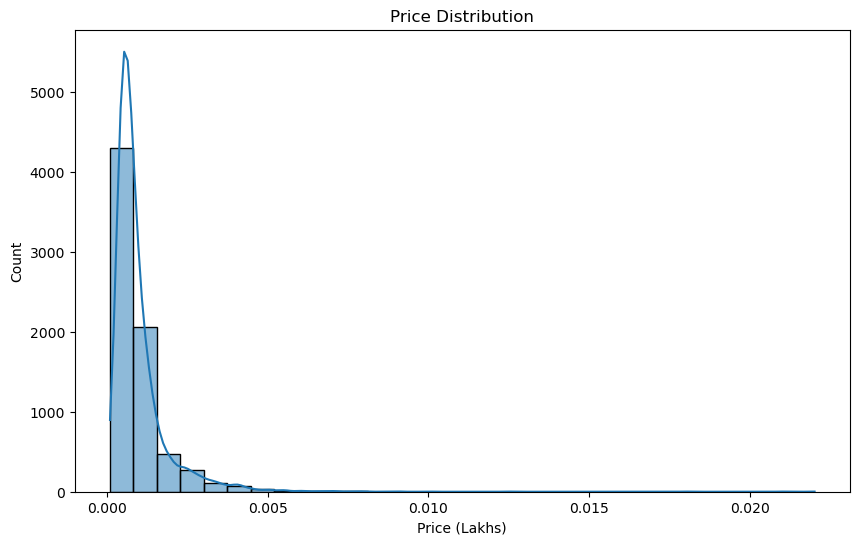

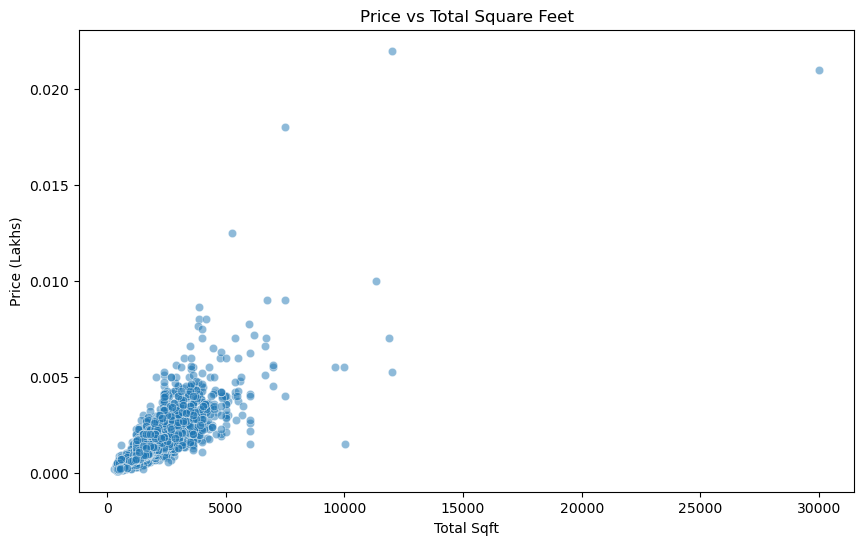

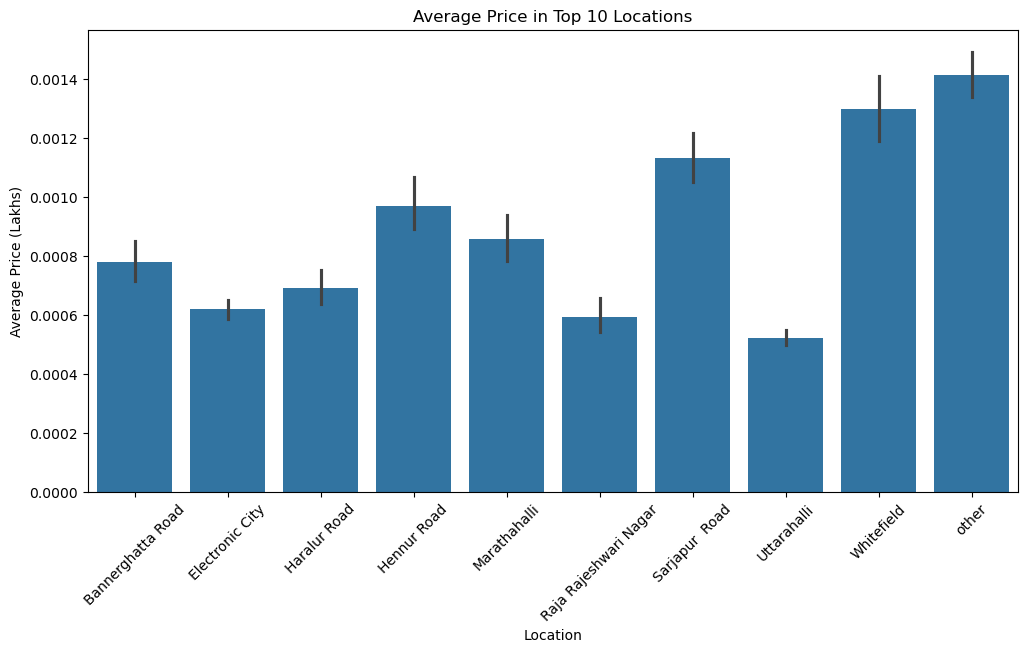

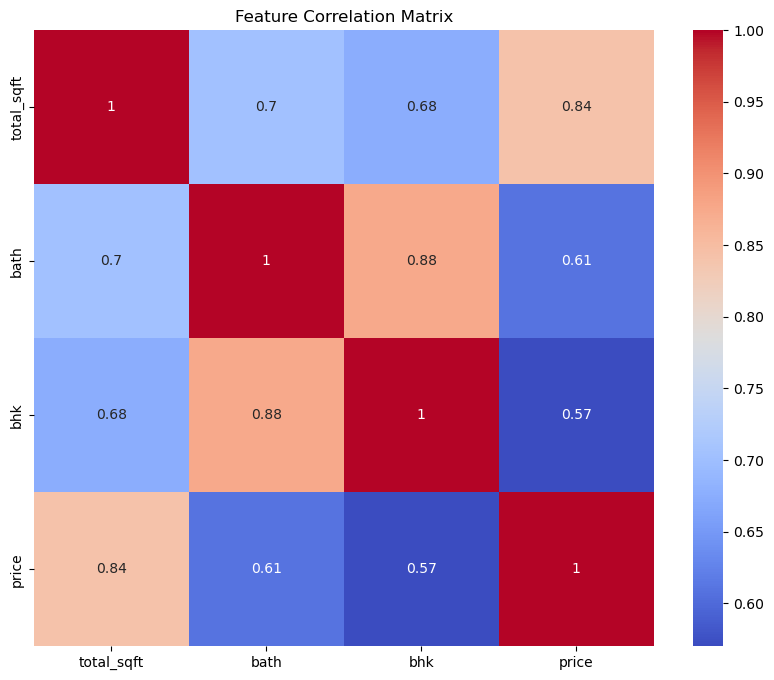

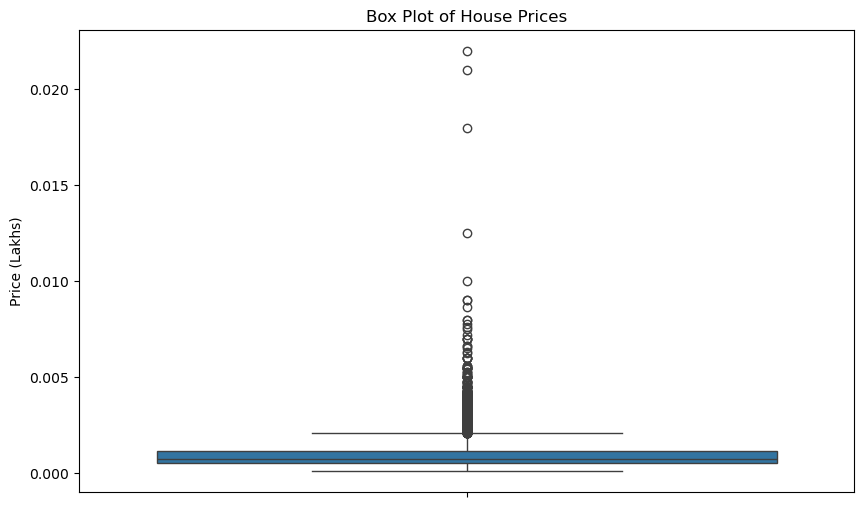

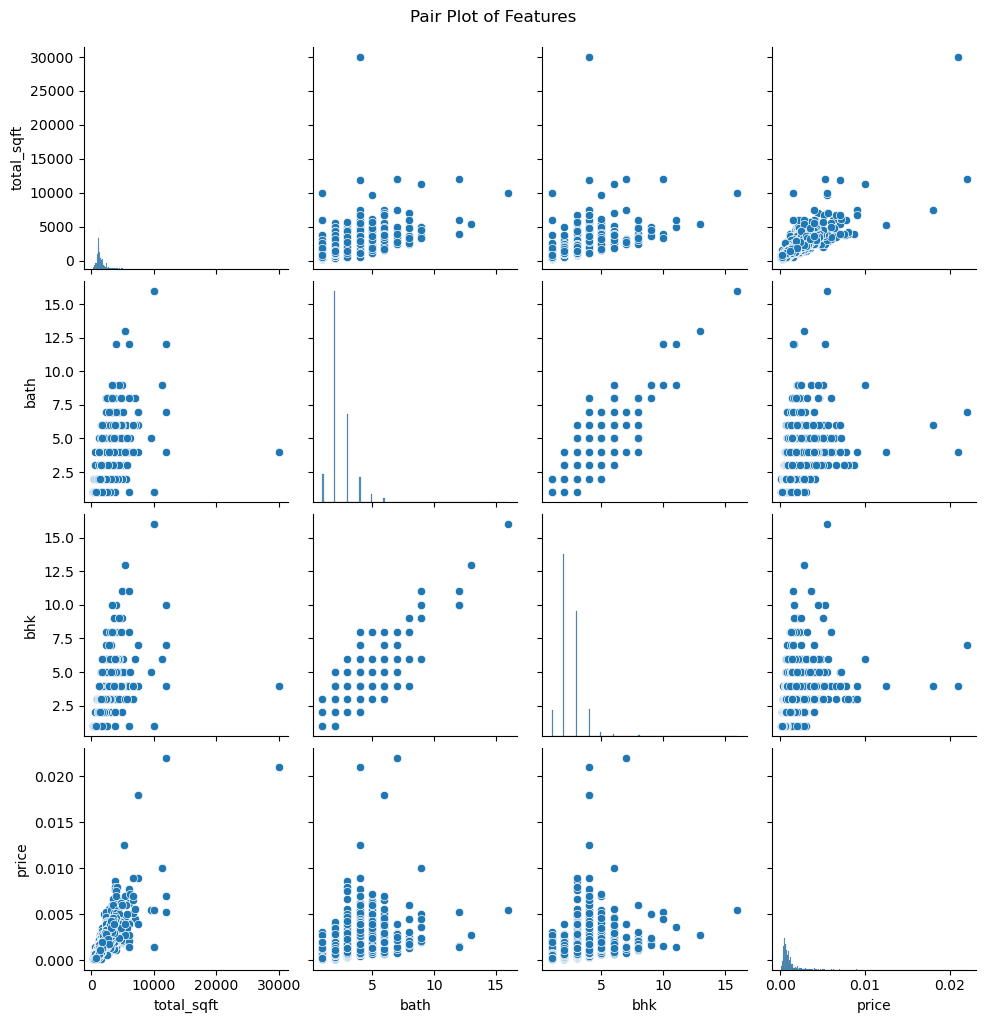

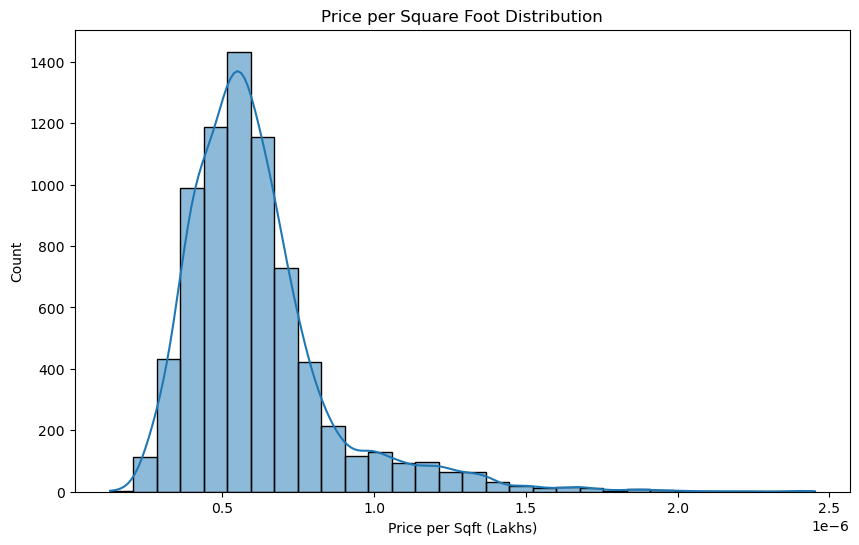

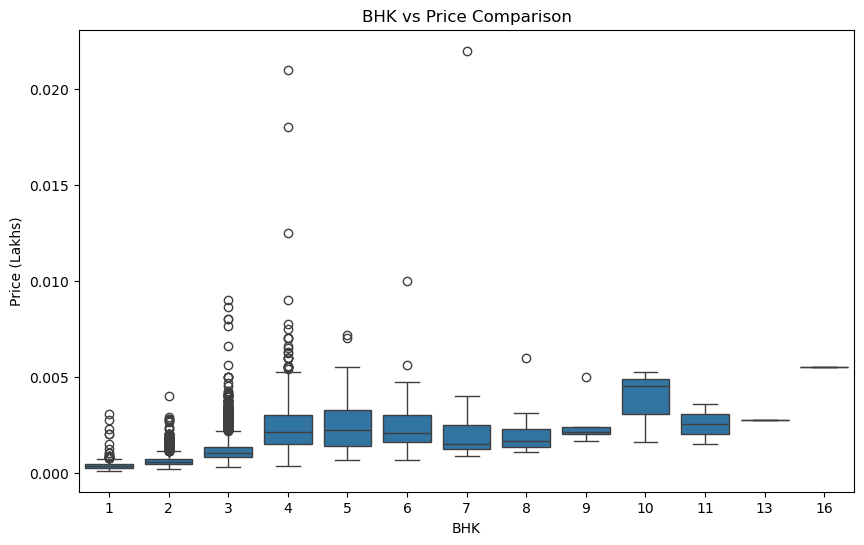

C:\Users\AMBAR KUMAR\AppData\Local\Temp\ipykernel_10324\1504236241.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bath', data=df, palette='Set2')


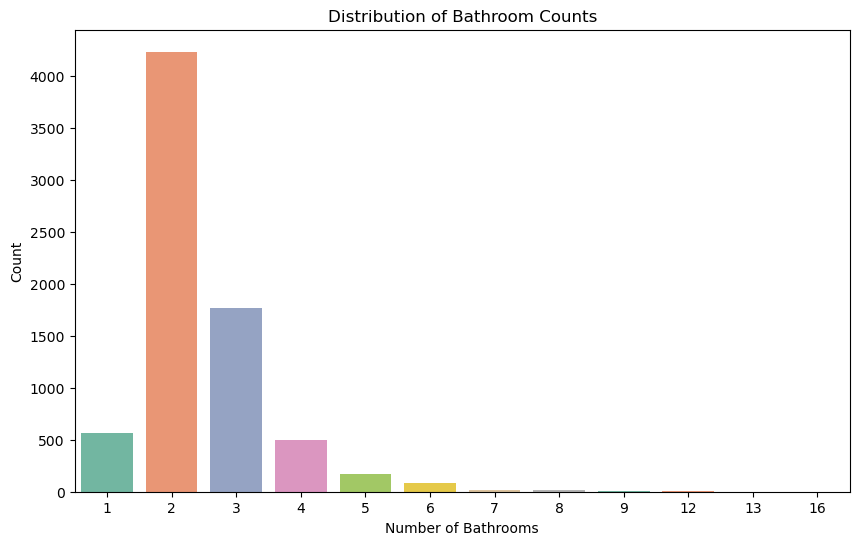

Skewness of Price: 6.262704108631431
Kurtosis of Price: 90.77349076112783


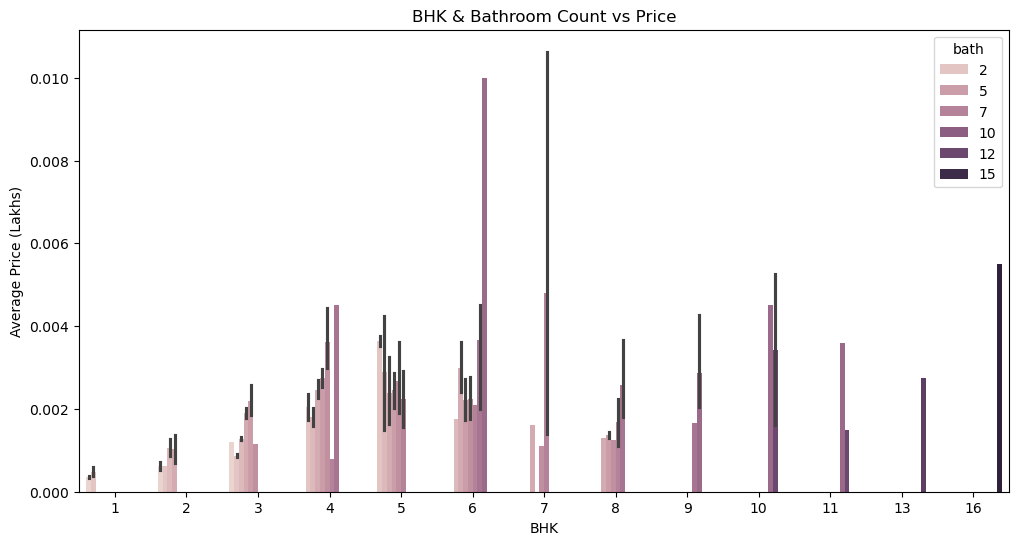

In [15]:
# Exploratory data analysis

# Convert price to Lakhs for better readability
df = pd.read_csv('data.csv')
df['price'] = df['price'] / 100000  

# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (Lakhs)')
plt.show()

# Price vs. Square Feet
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sqft', y='price', data=df, alpha=0.5)
plt.title('Price vs Total Square Feet')
plt.xlabel('Total Sqft')
plt.ylabel('Price (Lakhs)')
plt.show()

# Top 10 Locations by Average Price
top_locations = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.barplot(x='location', y='price', data=df[df['location'].isin(top_locations)], estimator=np.mean)
plt.title('Average Price in Top 10 Locations')
plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('Average Price (Lakhs)')
plt.show()

# Correlation Heatmap
numerical_features = ['total_sqft', 'bath', 'bhk', 'price']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Box Plot for Outliers in Price
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['price'])
plt.title('Box Plot of House Prices')
plt.ylabel('Price (Lakhs)')
plt.show()

# Pair Plot to Visualize Feature Relationships
sns.pairplot(df[['total_sqft', 'bath', 'bhk', 'price']])
plt.suptitle("Pair Plot of Features", y=1.02)
plt.show()

# Price per Square Foot Analysis
df['price_per_sqft'] = df['price'] / df['total_sqft']
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_sqft'], bins=30, kde=True)
plt.title('Price per Square Foot Distribution')
plt.xlabel('Price per Sqft (Lakhs)')
plt.show()

# BHK vs Price Comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='bhk', y='price', data=df)
plt.title('BHK vs Price Comparison')
plt.xlabel('BHK')
plt.ylabel('Price (Lakhs)')
plt.show()

# Bathroom Count Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='bath', data=df, palette='Set2')
plt.title('Distribution of Bathroom Counts')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
plt.show()

# Skewness & Kurtosis Check
from scipy.stats import skew, kurtosis

print(f"Skewness of Price: {skew(df['price'])}")
print(f"Kurtosis of Price: {kurtosis(df['price'])}")

# Price Trends by BHK & Bathrooms
plt.figure(figsize=(12, 6))
sns.barplot(x='bhk', y='price', hue='bath', data=df)
plt.title('BHK & Bathroom Count vs Price')
plt.xlabel('BHK')
plt.ylabel('Average Price (Lakhs)')
plt.show()

In [17]:
# Model Training with Hyperparameter Tuning & Saving
def train_model():
    X, y, _ = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('loc', OneHotEncoder(handle_unknown='ignore'), ['location']),
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), ['total_sqft', 'bath', 'bhk'])
        ]
    )
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("\nModel Evaluation Metrics:")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}\n")
    
    joblib.dump(best_model, 'house_price_model.pkl')
    print("Model saved as 'house_price_model.pkl'")
    return best_model

# Load Model Function
def load_saved_model():
    return joblib.load('house_price_model.pkl')


In [ ]:
# GUI for Prediction with Loading Animation
import os
import tkinter as tk
from tkinter import ttk, messagebox
from PIL import ImageTk, Image
import pandas as pd
import joblib

# Check if the model file exists
if os.path.exists("house_price_model.pkl"):
    model = joblib.load("house_price_model.pkl")
else:
    # Call functions to train and load the model
    train_model()
    load_saved_model()
    model = joblib.load("house_price_model.pkl")

class PricePredictorApp:
    def __init__(self, master):
        self.master = master
        master.title("SMART PROPERTY VALUATION")
        master.geometry("800x600")

        # Load background image
        try:
            self.bg_image = ImageTk.PhotoImage(Image.open("background.png"))
            bg_label = tk.Label(master, image=self.bg_image)
            bg_label.place(x=0, y=0, relwidth=1, relheight=1)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load background: {str(e)}")
            master.destroy()
            return

        # Main container frame
        self.main_frame = tk.Frame(master, bg="#e3e8c5", bd=5, relief=tk.GROOVE)
        self.main_frame.place(relx=0.5, rely=0.5, anchor="center")

        # Load model and data
        try:
            self.model = joblib.load('house_price_model.pkl')
            df = pd.read_csv('data.csv')
            self.locations = df['location'].unique().tolist()
        except Exception as e:
            messagebox.showerror("Error", f"Initialization failed: {str(e)}")
            master.destroy()
            return

        # Styling
        style = ttk.Style()
        style.configure("TCombobox", padding=5, font=("Arial", 12))
        style.configure("TButton", font=("Arial", 12, "bold"), padding=10, background="#4CAF50")
        style.map("TButton", background=[("active", "#6493de")])

        # GUI Components
        ttk.Label(self.main_frame, text="Smart Property Valuation", 
                font=("Arial", 16, "bold"), background="#6493de").grid(row=0, columnspan=2, pady=15)

        # Input fields
        ttk.Label(self.main_frame, text="Location:", font=("Arial", 12), background="#edbfb4").grid(row=1, padx=10, pady=8, sticky="w")
        self.location_var = tk.StringVar()
        self.location_cb = ttk.Combobox(self.main_frame, textvariable=self.location_var, 
                                      values=self.locations, font=("Arial", 12), width=25)
        self.location_cb.grid(row=1, column=1, padx=10, pady=8)

        ttk.Label(self.main_frame, text="Total Sqft:", font=("Arial", 12), background="#edbfb4").grid(row=2, padx=10, pady=8, sticky="w")
        self.sqft_entry = ttk.Entry(self.main_frame, font=("Arial", 12))
        self.sqft_entry.grid(row=2, column=1, padx=10, pady=8)

        ttk.Label(self.main_frame, text="Bathrooms:", font=("Arial", 12), background="#edbfb4").grid(row=3, padx=10, pady=8, sticky="w")
        self.bath_entry = ttk.Entry(self.main_frame, font=("Arial", 12))
        self.bath_entry.grid(row=3, column=1, padx=10, pady=8)

        ttk.Label(self.main_frame, text="BHK:", font=("Arial", 12), background="#edbfb4").grid(row=4, padx=10, pady=8, sticky="w")
        self.bhk_entry = ttk.Entry(self.main_frame, font=("Arial", 12))
        self.bhk_entry.grid(row=4, column=1, padx=10, pady=8)

        self.predict_btn = ttk.Button(self.main_frame, text="Predict Price", 
                                    command=self.predict_price)
        self.predict_btn.grid(row=5, columnspan=2, pady=15)

        self.result_label = ttk.Label(self.main_frame, text="", 
                                    font=("Arial", 14, "bold"), background="#dcf7f3")
        self.result_label.grid(row=6, columnspan=2)

        # Loading components
        self.loading_label = ttk.Label(self.main_frame, text="", 
                                      font=("Arial", 14), background="#e3e8c5")
        self.loading_label.grid(row=7, columnspan=2, pady=10)
        self.loading_label.grid_remove()

    def predict_price(self):
        try:
            # Validate inputs
            location = self.location_var.get()
            if not location:
                raise ValueError("Please select a location")
            sqft = float(self.sqft_entry.get())
            bath = float(self.bath_entry.get())
            bhk = float(self.bhk_entry.get())
        except ValueError as e:
            self.result_label.config(text=str(e) if str(e) else "Invalid input!", foreground="red")
            return

        # Disable button and clear previous result
        self.predict_btn.config(state="disabled")
        self.result_label.config(text="")
        
        # Show loading animation
        self.loading_label.grid()
        self.animate_loading(0)
        
        # Schedule prediction after 5 seconds
        self.master.after(5000, lambda: self.perform_prediction(location, sqft, bath, bhk))

    def animate_loading(self, step):
        dots = '.' * (step % 4)
        self.loading_label.config(text=f"Analyzing Market Trends{dots}")
        self.animation_id = self.master.after(500, self.animate_loading, step + 1)

    def perform_prediction(self, location, sqft, bath, bhk):
        try:
            # Create input DataFrame
            input_data = pd.DataFrame([[location, sqft, bath, bhk]],
                                    columns=['location', 'total_sqft', 'bath', 'bhk'])
            
            # Get prediction
            prediction = self.model.predict(input_data)[0]
            formatted_price = f"₹{prediction:,.2f} Lakhs"
            self.result_label.config(text=f"Estimated Property Value: {formatted_price}", 
                                   foreground="#2c3e50")
        except Exception as e:
            self.result_label.config(text=f"Prediction Error: {str(e)}", foreground="red")
        finally:
            # Clean up animation and UI
            self.master.after_cancel(self.animation_id)
            self.loading_label.grid_remove()
            self.predict_btn.config(state="normal")

if __name__ == "__main__":
    root = tk.Tk()
    app = PricePredictorApp(root)
    root.mainloop()